<a href="https://colab.research.google.com/github/Paul-mwaura/ML-Hackathons/blob/main/Uber_Nairobi_Ambulance_Perambulation_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uber Nairobi Ambulance Perambulation Challenge

## Business Understanding

<a href="https://zindi.africa/competitions/uber-nairobi-ambulance-perambulation-challenge">**Uber Nairobi Ambulance Perambulation Challenge**</a>

Road traffic collisions are the number one killer of children and young adults ages 5-29, and 8th leading cause of death worldwide. Post-crash care is one of the five pillars of road safety and a critical component for reducing morbidity and mortality.

When it comes to emergency response to road accidents, every second counts. With heavy traffic patterns and the unique layout of the city, finding the best locations to position emergency responders throughout the day as they wait to be called is critical in a city like Nairobi.

We’ve collected information on thousands of traffic accidents that have occurred in Nairobi, Kenya in 2018 and 2019. For this competition, you must use the training data (recorded crashes up to June 2019) along with supplementary data from Uber Movement, road survey data and weather patterns to identify patterns of risk across the city. You must then use these findings to place six virtual ambulances around the city, moving them around throughout the day with the goal of minimising the distance travelled when responding to crashes during the test period.

## Data Understanding


> The main dataset for this challenge (in Train.csv) is a record of crashes within Nairobi over 2018-19. Each crash has an associated datetime and location. Let's load the data and take a look.

## Loading the dataset

In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 11.3MB/s 
     |████████████████████████████████| 14.8MB 233kB/s 
     |████████████████████████████████| 6.5MB 42.9MB/s 


In [ ]:
!pip install contextily

     |████████████████████████████████| 18.3MB 254kB/s 


In [ ]:
!pip install geovoronoi

In [ ]:
# load required libraries
import pandas as pd
import numpy as np
import geopandas as gpd 
from google.colab import files

import contextily as ctx
import matplotlib.pyplot as plt
import time

# processing geojson files
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# clustering + visualisation
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

from scipy.spatial import Voronoi, voronoi_plot_2d

**Train Data**

In [ ]:
# Load the data
train = pd.read_csv('Train.csv', parse_dates=['datetime'])
print(train.shape)
train.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


In [ ]:
train.describe()

,uid,latitude,longitude
count,6318.000000,6318.000000,6318.000000
mean,3159.500000,-1.270338,36.855459
std,1823.993832,0.125157,0.112866
min,1.000000,-3.050000,36.332202
25%,1580.250000,-1.316585,36.802048
50%,3159.500000,-1.271709,36.844591
75%,4738.750000,-1.233746,36.895642
max,6318.000000,-0.565402,37.879490


In [ ]:
df = train.copy()

## Exploratory Data Analysis

**Train Dataset**


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


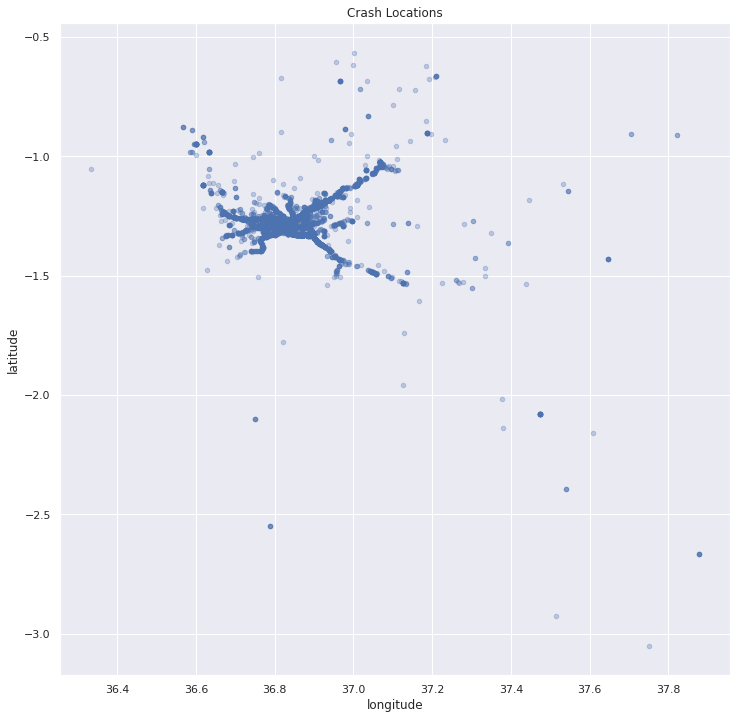

In [ ]:
# Plot the crashes
train.plot(x='longitude', y='latitude', kind='scatter', figsize=(12, 12), alpha=0.3, title='Crash Locations')

> Rather than trying to predict accident locations or the number of accidents in a given timeframe, we are instead asked to come up with an ambulance deployment schedule that will minimise distance travelled.

> This is of course a simplification of the problem, but by solving this you will hopefully develop strategies that can be used going forward.

In [ ]:
# View the submission format
ss = pd.read_csv('SampleSubmission.csv', parse_dates=['date'])
ss.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-07-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-07-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-07-01 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-07-01 09:00:00,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-07-01 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0


Start with 6 random locations that are close to the center of the city.


> Generated values of Ambulance Latitudes and Longitudes, that are close to the center of the city.


In [ ]:
# Convert Train data to numpy array.
#data = train.iloc[:, -2:].to_numpy()
data = train.iloc[:, -2:].copy()
data.head()

,latitude,longitude
0,-1.188850,36.931382
1,-0.662939,37.208730
2,-0.662939,37.208730
3,-1.288087,36.826583
4,-1.188850,36.931382


In [ ]:
#Slpiting the date time column 
train['datetime'] = train['datetime'].apply(pd.to_datetime)
train['date'] = [d.date() for d in train['datetime']]
train['time'] = [t.time() for t in train['datetime']]


# creating three new columns for hours, minutes and seconds respectively.
# create a list of the new columns ['year','month','day'].
# the splitting happens occurs on the time column.
# pandas.Series.astype --> casts a pandas object to a specified dtype dtype
# pandas.Series.str.split --> Splits the string in the Series/Index from the beginning, at the specified delimiter string
# expand == If True, return DataFrame/MultiIndex expanding dimensionality
#
train[['year','month','day']] = train['date'].astype(str).str.split('-', expand=True).astype(int)

train.head()

,uid,datetime,latitude,longitude,date,time,year,month,day
0,1,2018-01-01 00:25:46,-1.188850,36.931382,2018-01-01,00:25:46,2018,1,1
1,2,2018-01-01 02:02:39,-0.662939,37.208730,2018-01-01,02:02:39,2018,1,1
2,3,2018-01-01 02:31:49,-0.662939,37.208730,2018-01-01,02:31:49,2018,1,1
3,4,2018-01-01 03:04:01,-1.288087,36.826583,2018-01-01,03:04:01,2018,1,1
4,5,2018-01-01 03:58:49,-1.188850,36.931382,2018-01-01,03:58:49,2018,1,1


In [ ]:
# creating three new columns for hours, minutes and seconds respectively.
# create a list of the new columns ['hr','min','sec'].
# the splitting happens occurs on the time column.
# pandas.Series.astype --> casts a pandas object to a specified dtype dtype
# pandas.Series.str.split --> Splits the string in the Series/Index from the beginning, at the specified delimiter string
# expand == If True, return DataFrame/MultiIndex expanding dimensionality
#
train[['hr','min','sec']] = train['time'].astype(str).str.split(':', expand=True).astype(int)
train.head()

,uid,datetime,latitude,longitude,date,time,year,month,day,hr,min,sec
0,1,2018-01-01 00:25:46,-1.188850,36.931382,2018-01-01,00:25:46,2018,1,1,0,25,46
1,2,2018-01-01 02:02:39,-0.662939,37.208730,2018-01-01,02:02:39,2018,1,1,2,2,39
2,3,2018-01-01 02:31:49,-0.662939,37.208730,2018-01-01,02:31:49,2018,1,1,2,31,49
3,4,2018-01-01 03:04:01,-1.288087,36.826583,2018-01-01,03:04:01,2018,1,1,3,4,1
4,5,2018-01-01 03:58:49,-1.188850,36.931382,2018-01-01,03:58:49,2018,1,1,3,58,49


In [ ]:
# creating a weekday column to represent the days in numeric form.
# using the lambda anonymous function
# using the python datetime.weekday() --> returns the day of the week as an integer, where Monday is 0 and Sunday is 6.
#
train['weekday'] = train['date'].apply (lambda x:x.weekday() )
train.head()

,uid,datetime,latitude,longitude,date,time,year,month,day,hr,min,sec,weekday
0,1,2018-01-01 00:25:46,-1.188850,36.931382,2018-01-01,00:25:46,2018,1,1,0,25,46,0
1,2,2018-01-01 02:02:39,-0.662939,37.208730,2018-01-01,02:02:39,2018,1,1,2,2,39,0
2,3,2018-01-01 02:31:49,-0.662939,37.208730,2018-01-01,02:31:49,2018,1,1,2,31,49,0
3,4,2018-01-01 03:04:01,-1.288087,36.826583,2018-01-01,03:04:01,2018,1,1,3,4,1,0
4,5,2018-01-01 03:58:49,-1.188850,36.931382,2018-01-01,03:58:49,2018,1,1,3,58,49,0


In [ ]:
# Unique values of the Hour variable.
#
unique_hr = train['hr'].unique()
print(f"Unique Hour Values:\n {unique_hr}")

for i, hr in enumerate(unique_hr):
  train['hour_type'] = train['hr']


# chronologically mapping the numeric day of the week with it's respective name
# using a dictionary.
#
week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
train['weekday'] = train['weekday'].map(week)

# Mapping Day Type as either Day or Night.
#
hr_type = {7:'day',8:'day',9:'day',10:'day',11:'day',12:'day',13:'day',14:'day',15:'day',16:'day',17:'day',18:'day',
           19:'night',20:'night',21:'night',22:'night',23:'night',0:'night',1:'night',2:'night',3:'night',4:'night',5:'night',6:'night'}

train['hour_type'] = train['hour_type'].map(hr_type)
train.head()

Unique Hour Values:
 [ 0  2  3  4  5  7  9 10 11 14  8 12 13 15 16  1  6 17 18 19 22 23 20 21]


,uid,datetime,latitude,longitude,date,time,year,month,day,hr,min,sec,weekday,hour_type
0,1,2018-01-01 00:25:46,-1.188850,36.931382,2018-01-01,00:25:46,2018,1,1,0,25,46,Monday,night
1,2,2018-01-01 02:02:39,-0.662939,37.208730,2018-01-01,02:02:39,2018,1,1,2,2,39,Monday,night
2,3,2018-01-01 02:31:49,-0.662939,37.208730,2018-01-01,02:31:49,2018,1,1,2,31,49,Monday,night
3,4,2018-01-01 03:04:01,-1.288087,36.826583,2018-01-01,03:04:01,2018,1,1,3,4,1,Monday,night
4,5,2018-01-01 03:58:49,-1.188850,36.931382,2018-01-01,03:58:49,2018,1,1,3,58,49,Monday,night


In [ ]:
# Group by Hour Type(Day or Night)
pd.DataFrame(train.groupby('hour_type')['weekday'].value_counts().sort_values(ascending=False))

weekday
hour_type weekday           
day       Tuesday        703
          Wednesday      663
          Friday         641
          Saturday       611
          Thursday       582
          Monday         523
          Sunday         415
night     Tuesday        378
          Friday         364
          Wednesday      362
          Monday         344
          Thursday       300
          Saturday       238
          Sunday         194

#### Scoring

You can re-create the scoring process by creating your own test set and using the following function:

Text(0.5, 0, 'Latitude')

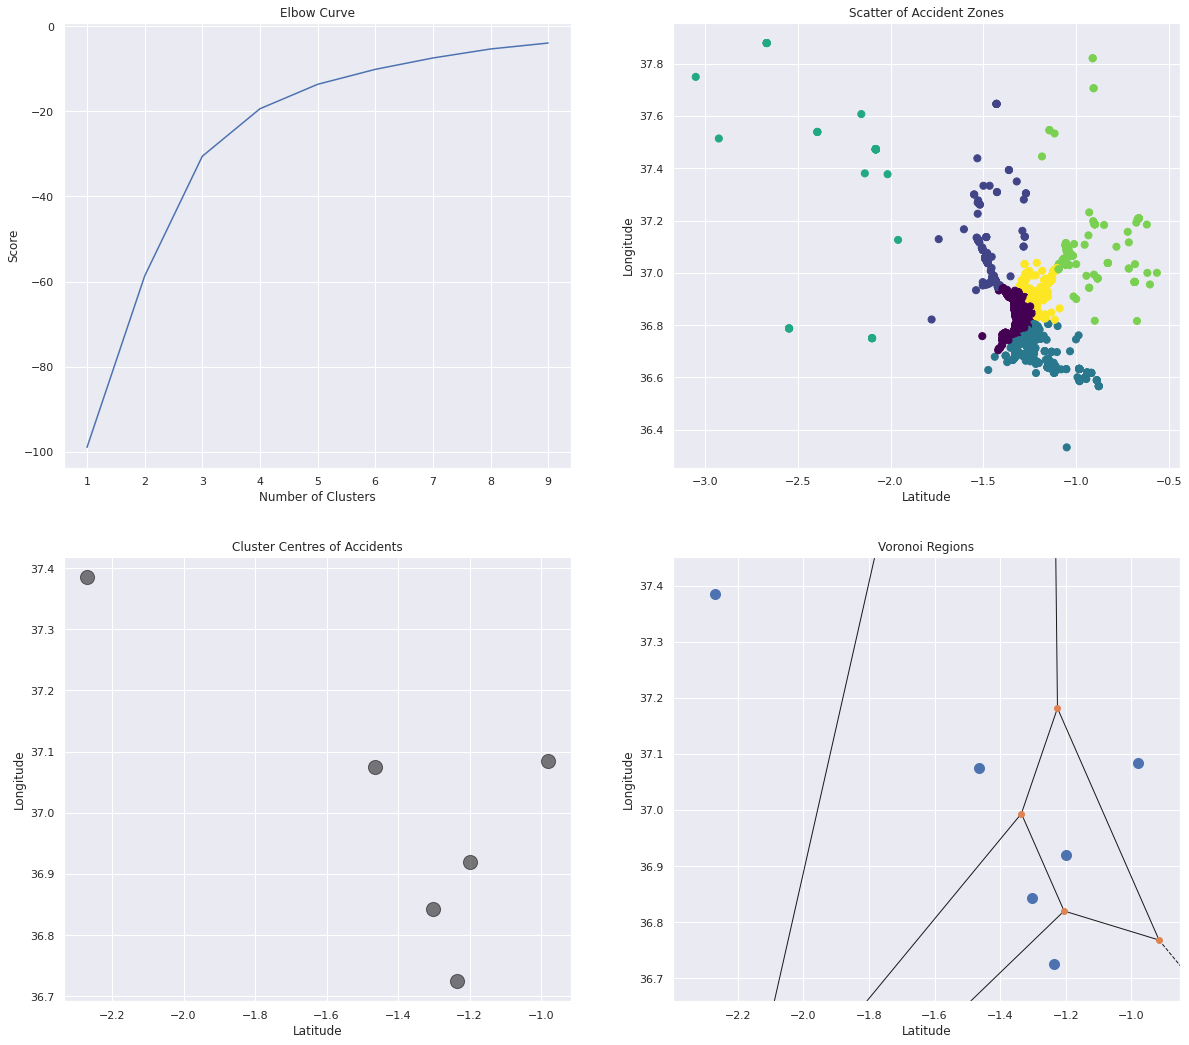

In [ ]:
# clustering

K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = train[['latitude']]
X_axis = train[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Variable with the Longitude and Latitude
X=train.loc[:,['datetime','latitude','longitude']]

kmeans = KMeans(n_clusters = 6, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point

# ===== clusters
#X.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')


# ===== road segments locations


fig, axs = plt.subplots(2, 2,figsize=(20, 18))
axs[0, 0].plot(K_clusters, score)
axs[0, 0].set_title('Elbow Curve')
axs[0, 0].set_ylabel('Score')
axs[0, 0].set_xlabel('Number of Clusters')

axs[1,0].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5,cmap='viridis')
axs[1, 0].set_title('Cluster Centres of Accidents')
axs[1, 0].set_ylabel('Longitude')
axs[1, 0].set_xlabel('Latitude')

axs[0,1].scatter(x = X['latitude'], y = X['longitude'], c=labels, s=50, cmap='viridis')
axs[0, 1].set_title('Scatter of Accident Zones')
axs[0, 1].set_ylabel('Longitude')
axs[0, 1].set_xlabel('Latitude')

points = pd.DataFrame([centers[:, 0], centers[:, 1]]).transpose()
vor = Voronoi(points)

# plot
voronoi_plot_2d(vor,ax=axs[1,1],point_size=20)
axs[1, 1].set_title('Voronoi Regions')
axs[1, 1].set_ylabel('Longitude')
axs[1, 1].set_xlabel('Latitude')

In [ ]:
## per 3 hours
train['idx'] = 1
train_3hours = train.resample('3H', on='datetime')['idx'].count().reset_index()
train_3hours['datetime'] = train_3hours['datetime'].dt.hour

train_3hours = train_3hours.groupby('datetime').sum().reset_index()
train_pd_3hours = pd.DataFrame(train_3hours)

In [ ]:
# Variable with the Longitude and Latitude
X=train.loc[:,['datetime','latitude','longitude']]
X.head(10)

kmeans = KMeans(n_clusters = 6, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point

points['cluster_label'] = range(0,6)
points.columns = ['lat','lon','cluster_label']

point = points

merged = X.merge(point,on='cluster_label',how='left')
merged['hour'] = merged['datetime'].dt.hour

train_pd_3hours.columns = ['hour','idx']

mg = merged.merge(train_pd_3hours,on='hour',how='left')
mg.head()
amb = mg[['latitude', 'longitude']]
amb.describe()

,latitude,longitude
count,6318.000000,6318.000000
mean,-1.270338,36.855459
std,0.125157,0.112866
min,-3.050000,36.332202
25%,-1.316585,36.802048
50%,-1.271709,36.844591
75%,-1.233746,36.895642
max,-0.565402,37.879490


In [ ]:
amb.to_csv("ambulance_clusters.csv")

In [ ]:
train.describe()

,uid,latitude,longitude,year,month,day,hr,min,sec,idx
count,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.0
mean,3159.500000,-1.270338,36.855459,2018.304210,5.317031,15.103989,11.638651,29.541469,29.311966,1.0
std,1823.993832,0.125157,0.112866,0.460109,3.194254,8.818403,5.653580,17.149118,17.014833,0.0
min,1.000000,-3.050000,36.332202,2018.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0
25%,1580.250000,-1.316585,36.802048,2018.000000,3.000000,7.000000,7.000000,15.000000,9.000000,1.0
50%,3159.500000,-1.271709,36.844591,2018.000000,5.000000,15.000000,11.000000,30.000000,29.000000,1.0
75%,4738.750000,-1.233746,36.895642,2019.000000,8.000000,23.000000,17.000000,44.000000,39.000000,1.0
max,6318.000000,-0.565402,37.879490,2019.000000,12.000000,31.000000,23.000000,59.000000,59.000000,1.0


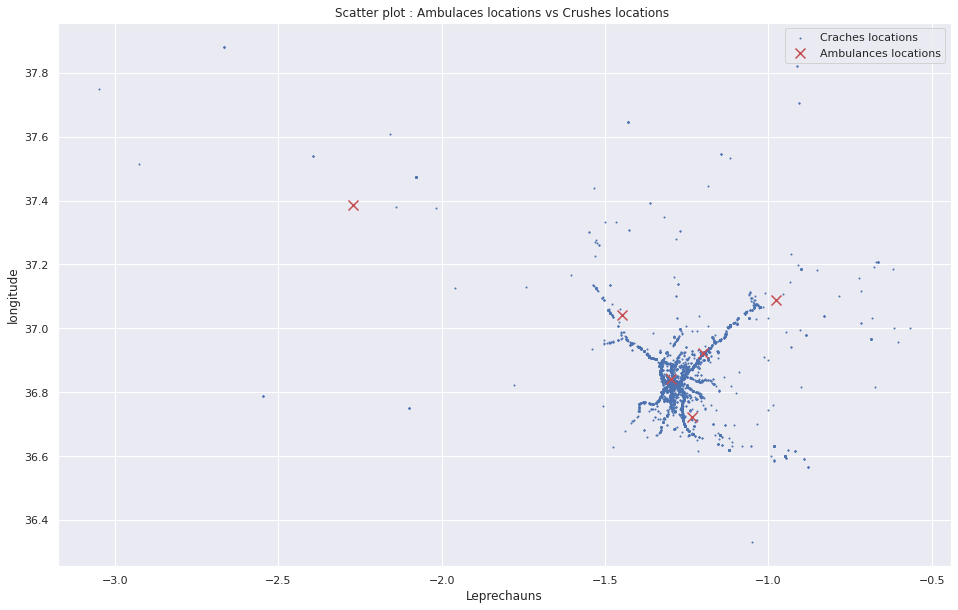

In [ ]:

kmeans_global = KMeans(n_clusters=6, random_state=500).fit(train[['latitude','longitude']])

fig, axs = plt.subplots(figsize=(16, 10))

plt.scatter(x = train['latitude'],y=train['longitude'], s=1, label='Craches locations' )
plt.scatter(x=kmeans_global.cluster_centers_[:,0], y=kmeans_global.cluster_centers_[:,1],marker="x",
            color='r',label='Ambulances locations',s=100)
axs.set_title('Scatter plot : Ambulaces locations vs Crushes locations ')
plt.xlabel("Leprechauns")
plt.ylabel("longitude")
plt.legend()
plt.show()

In [ ]:
train.head(2)

,uid,datetime,latitude,longitude,date,time,year,month,day,hr,min,sec,weekday,hour_type,idx
0,1,2018-01-01 00:25:46,-1.188850,36.931382,2018-01-01,00:25:46,2018,1,1,0,25,46,Monday,night,1
1,2,2018-01-01 02:02:39,-0.662939,37.208730,2018-01-01,02:02:39,2018,1,1,2,2,39,Monday,night,1


In [ ]:
train['weekday']  = pd.get_dummies(train['weekday'])
train['hour_type']  = pd.get_dummies(train['hour_type'])
train.head()

,uid,datetime,latitude,longitude,date,time,year,month,day,hr,min,sec,weekday,hour_type,idx
0,1,2018-01-01 00:25:46,-1.188850,36.931382,2018-01-01,00:25:46,2018,1,1,0,25,46,0,0,1
1,2,2018-01-01 02:02:39,-0.662939,37.208730,2018-01-01,02:02:39,2018,1,1,2,2,39,0,0,1
2,3,2018-01-01 02:31:49,-0.662939,37.208730,2018-01-01,02:31:49,2018,1,1,2,31,49,0,0,1
3,4,2018-01-01 03:04:01,-1.288087,36.826583,2018-01-01,03:04:01,2018,1,1,3,4,1,0,0,1
4,5,2018-01-01 03:58:49,-1.188850,36.931382,2018-01-01,03:58:49,2018,1,1,3,58,49,0,0,1


In [ ]:
train.describe()

,uid,latitude,longitude,year,month,day,hr,min,sec,weekday,hour_type,idx
count,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.000000,6318.0
mean,3159.500000,-1.270338,36.855459,2018.304210,5.317031,15.103989,11.638651,29.541469,29.311966,0.159069,0.654954,1.0
std,1823.993832,0.125157,0.112866,0.460109,3.194254,8.818403,5.653580,17.149118,17.014833,0.365770,0.475421,0.0
min,1.000000,-3.050000,36.332202,2018.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1580.250000,-1.316585,36.802048,2018.000000,3.000000,7.000000,7.000000,15.000000,9.000000,0.000000,0.000000,1.0
50%,3159.500000,-1.271709,36.844591,2018.000000,5.000000,15.000000,11.000000,30.000000,29.000000,0.000000,1.000000,1.0
75%,4738.750000,-1.233746,36.895642,2019.000000,8.000000,23.000000,17.000000,44.000000,39.000000,0.000000,1.000000,1.0
max,6318.000000,-0.565402,37.879490,2019.000000,12.000000,31.000000,23.000000,59.000000,59.000000,1.000000,1.000000,1.0


In [ ]:
amb_loc = np.random.random ([6,2]) * 0.04
amb_loc = amb_loc + np.array([-1.270338, 36.855459])
amb_loc = pd.DataFrame(amb_loc, columns=['latitude', 'longitude'])
amb_loc

,latitude,longitude
0,-1.244856,36.873142
1,-1.256563,36.888976
2,-1.264061,36.888866
3,-1.259626,36.867697
4,-1.243228,36.859470
5,-1.234554,36.871792


In [ ]:
train.columns

Index(['uid', 'datetime', 'latitude', 'longitude', 'date', 'time', 'year',
       'month', 'day', 'hr', 'min', 'sec', 'weekday', 'hour_type', 'idx'],
      dtype='object')

In [ ]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon, weekday, hour_type in ref[['datetime', 'latitude', 'longitude', 'weekday', 'hour_type']].values:
        row = sub.loc[sub.date < date].tail(1) # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(1,6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
            
        total_distance += min(dists)
    return total_distance.min()

In [ ]:
# Test set
reference = train.loc[train.datetime > '2019-01-01'] # Using 2019 as our test set
reference.head(2)

,uid,datetime,latitude,longitude,date,time,year,month,day,hr,min,sec,weekday,hour_type,idx
4396,4397,2019-01-01 11:16:39,-1.298568,36.806244,2019-01-01,11:16:39,2019,1,1,11,16,39,0,1,1
4397,4398,2019-01-01 13:29:39,-1.316169,36.895726,2019-01-01,13:29:39,2019,1,1,13,29,39,0,1,1


In [ ]:
train.iloc[:5, 2:4]

,latitude,longitude
0,-1.188850,36.931382
1,-0.662939,37.208730
2,-0.662939,37.208730
3,-1.288087,36.826583
4,-1.188850,36.931382


In [ ]:
# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})

for ambulance in range(6):
  sub['A'+str(ambulance)+'_Latitude'] = amb_loc.latitude[ambulance]
  sub['A'+str(ambulance)+'_Longitude'] = amb_loc.longitude[ambulance]

score(sub, reference)

176.55268327344447

In [ ]:
sub.to_csv("submission_data.csv")

In [ ]:
submission = pd.read_csv("submission_data.csv")
submission.head()

,Unnamed: 0,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,0,2019-01-01 00:00:00,-1.244856,36.873142,-1.256563,36.888976,-1.264061,36.888866,-1.259626,36.867697,-1.243228,36.85947,-1.234554,36.871792
1,1,2019-01-01 03:00:00,-1.244856,36.873142,-1.256563,36.888976,-1.264061,36.888866,-1.259626,36.867697,-1.243228,36.85947,-1.234554,36.871792
2,2,2019-01-01 06:00:00,-1.244856,36.873142,-1.256563,36.888976,-1.264061,36.888866,-1.259626,36.867697,-1.243228,36.85947,-1.234554,36.871792
3,3,2019-01-01 09:00:00,-1.244856,36.873142,-1.256563,36.888976,-1.264061,36.888866,-1.259626,36.867697,-1.243228,36.85947,-1.234554,36.871792
4,4,2019-01-01 12:00:00,-1.244856,36.873142,-1.256563,36.888976,-1.264061,36.888866,-1.259626,36.867697,-1.243228,36.85947,-1.234554,36.871792


> This scoring function can be used for local testing without needing to submit on Zindi. Lower is better. Experiment with specifying set locations for all 6 ambulances, and see how low you can get your score.


In [ ]:
# Plot crashes and ambulance locations
ax = df.plot(y='latitude', x='longitude', kind='scatter', figsize=(16, 10), label='crash locations')
#ax.scatter(initial_loc.iloc[:,0].values, initial_loc.iloc[:,0].values, c='red', label='initial ambulance locs')
ax.scatter(amb_loc.iloc[:,1].values, amb_loc.iloc[:,0].values, c='yellow', label='final ambulance locs')
ax.legend()

#### Weather Data
>>
Some weatehr variables form the GFS dataset are provided, covering the greater Nairobi area. Let's take a quick look at the dataset before moving on:

In [ ]:
weather = pd.read_csv('Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
weather.head()

In [ ]:
w_null = weather[~weather.isnull()]
w_null.shape

In [ ]:
# Interestingly, Kenya has two rainy seasons per year!
weather.set_index('Date')['precipitable_water_entire_atmosphere'].rolling(10).mean().plot()

#### Road Survey Data
>>
The road survey data contains many different measurements for each surveyed road segment. Unfortunately we can't access the raw data, and must work 'in the dark' in terms of what the column headings mean. However, the naming convention does at least show which columns may be related.
>>
To locate the road segments geographically, a geojson file is provided. Here is an example of merging the survey data with the segments and visualizing the result.

In [ ]:
# Load the survey data
road_surveys = pd.read_csv('Segment_info.csv')
road_surveys.head()

In [ ]:
# Load the map
road_segment_locs = gpd.read_file('segments_geometry.geojson')
road_segment_locs.head()

In [ ]:
# Because this is a geodataframe, we can plot it
road_segment_locs.plot()

In [ ]:
# Let's merge the two and color by one of the survey columns
segments_merged = pd.merge(road_segment_locs, road_surveys, on='segment_id', how='left')
segments_merged.plot(column='55_90', figsize=(20, 8))

> This data will come in useful if you're trying to predict the number of crashes along a particular road, or within a specified region.

**Adding Uber Data**

You can access speed data from https://movement.uber.com/explore/nairobi/speeds and clicking 'Download Data'. Here we'll load in the speeds from January 2019 and explore the data briefly.

In [ ]:
"""speeds = pd.read_csv('../uber_data/movement-speeds-hourly-nairobi-2019-1.csv', parse_dates=['utc_timestamp'])
speeds.head()"""

In [ ]:
"""# Plot speeds over time for a specific OSM way
way = speeds.loc[speeds.osm_way_id == 133901081]
way = way.set_index('utc_timestamp')
way.resample('1h').mean().plot(y='speed_kph_mean')"""

In [ ]:
"""way.resample('1D').mean().plot(y='speed_kph_mean')"""

>>
You can use any and all data available through Uber Movement, including linking the speeds data to OSM segments, downloading quarterly statistics, using the Movement Data Toolkit etc.
>>
You can find much more info about working with the speeds data here: https://medium.com/uber-movement/working-with-uber-movement-speeds-data-cc01d35937b3 - including how to link the segment_id with OSM data

#### What Next?

There are many ways you could approach this challenge. For example, you could:

Create a model to predict the liklihood of an accident given a location, the features of the nearby road segments, the weather, the traffic speed and the time of day
Use this model to predict the probability of crashes for different times+locations over the test period, and then sample from this probability distribution to generate plausible crash locations.
Use an optimization technique to minimise the travel distance for the ambulances to your fake crash points.
This might seem too complicated - perhaps simply picking 6 fixed locations based on the existing data will be enough? Or maybe it's worth setting separate locations during busy traffic times?

Perhaps a Reinforcement Learning aproach will do well?

Or maybe you can see a totally different way to solve this!

Share your ideas on the discussion boards, and let's see how innovative we can be :)



## Data Cleaning

In [ ]:
# Check for null values
train.isna().sum().sort_values(ascending=True)

In [ ]:
weather.isna().sum().sort_values(ascending=True)

In [ ]:
weather['precipitable_water_entire_atmosphere'] = weather['precipitable_water_entire_atmosphere'].fillna(weather['precipitable_water_entire_atmosphere'].mean())
weather['relative_humidity_2m_above_ground'] = weather['relative_humidity_2m_above_ground'].fillna(weather['relative_humidity_2m_above_ground'].mean())
weather['specific_humidity_2m_above_ground'] = weather['specific_humidity_2m_above_ground'].fillna(weather['specific_humidity_2m_above_ground'].mean())
weather['temperature_2m_above_ground'] = weather['temperature_2m_above_ground'].fillna(weather['temperature_2m_above_ground'].mean())
weather['u_component_of_wind_10m_above_ground'] = weather['u_component_of_wind_10m_above_ground'].fillna(weather['u_component_of_wind_10m_above_ground'].mean())
weather['v_component_of_wind_10m_above_ground'] = weather['v_component_of_wind_10m_above_ground'].fillna(weather['v_component_of_wind_10m_above_ground'].mean())

weather.isna().any()

**Merge Train data with weather data**

In [ ]:
train.head()

In [ ]:
weather.shape

In [ ]:
segments_merged.shape

In [ ]:

train['date'] = pd.to_datetime(train['datetime']).dt.date
train['time'] = pd.to_datetime(train['datetime']).dt.time
train.head()

In [ ]:
# creating three new columns for hours, minutes and seconds respectively.
# create a list of the new columns ['hr','min','sec'].
# the splitting happens occurs on the time column.
# pandas.Series.astype --> casts a pandas object to a specified dtype dtype
# pandas.Series.str.split --> Splits the string in the Series/Index from the beginning, at the specified delimiter string
# expand == If True, return DataFrame/MultiIndex expanding dimensionality
#
train[['hr','min','sec']] = train['time'].astype(str).str.split(':', expand=True).astype(int)
train.head()

In [ ]:
# creating a weekday column to represent the days in numeric form.
# using the lambda anonymous function
# using the python datetime.weekday() --> returns the day of the week as an integer, where Monday is 0 and Sunday is 6.
#
train['weekday'] = train['date'].apply (lambda x:x.weekday() )
train.head()

In [ ]:
# chronologically mapping the numeric day of the week with it's respective name
# using a dictionary.
#
week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
train['weekday'] = train['weekday'].map(week)
train.head()

In [ ]:
!pip install --upgrade fastcore -q
!pip install --upgrade fastai -q

In [ ]:
from fastai.vision.all import * # Needs latest version, and sometimes a restart of the runtime after the pip installs

In [ ]:
# Ambulance Locations
amb_locs = torch.randn(6, 2) * 0.04 # 6 pairs of random numbers, made fairly small
amb_locs = amb_locs + tensor(-1.27, 36.85) # Centered around the middle of town
amb_locs.requires_grad_() # Tell pytorch to calculate gradients
initial_locs = amb_locs.clone() # Save originals for later
amb_locs # View our set of initial locations

In [ ]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon, weekday in ref[['datetime', 'latitude', 'longitude',	'weekday']].values:
        row = sub.loc[sub.date < date].tail(1) # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance

In [ ]:
# Example:

# Test set
reference = train.loc[train.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = 0
    sub['A'+str(ambulance)+'_Longitude'] = 0

# Place an ambulance in the center of the city:
sub['A'+str(ambulance)+'_Latitude'] = 37.32
sub['A'+str(ambulance)+'_Longitude'] = -1.2

score(sub, reference)

In [ ]:
sub.to_csv()

## Implementing the Solution

## Challenging the Solution